In [1]:
%matplotlib inline
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
import lightgbm as lgb
from sklearn.svm import NuSVR, SVR, LinearSVR
from scipy import stats


/anaconda2/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [11]:
# rmsle
def rmsle(y, y_pred):
    return mean_squared_error(y, y_pred)

In [12]:
def ohe(input_data, col, col_dict):
    x = input_data[col].fillna('NA')
    y = x.astype('category',categories=col_dict[col])
    return pd.get_dummies(y,prefix=col)
    

In [13]:
def filter_col_by_coor(X_train,y_train):
    y = np.abs(X_train.corrwith(y_train)).sort_values(ascending=False)
    y = y[y>0.005]
    X_train =  X_train[y.index]
    
    # Create correlation matrix
    corr_matrix = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
    
    cols_retain = []
    for col in list(X_train.columns.values):
        if col not in to_drop:
            cols_retain.append(col)
    
    return X_train[cols_retain]
    
    

In [14]:
def get_features(input_data,ohe_cols,sel_cols, ro, col_dict,cols=None):
    
    input_data['porch'] = input_data['3SsnPorch'] + input_data['WoodDeckSF'] + input_data['OpenPorchSF'] + input_data['EnclosedPorch'] + input_data['ScreenPorch']
    input_data['SF'] = input_data['1stFlrSF'] + input_data['2ndFlrSF'] + input_data['BsmtFinSF1'] + input_data['BsmtFinSF2'] + input_data['TotalBsmtSF']
    input_data['LowQualFinSFPercent'] = 100 - (input_data['LowQualFinSF']*100)/input_data['SF']
    input_data['baths'] = input_data['BsmtFullBath'] + input_data['BsmtHalfBath'] + input_data['FullBath'] + input_data['HalfBath']
    
    
    
    
    features = input_data[sel_cols]
    features['LotFrontage'] = input_data['LotFrontage'].fillna(input_data['LotArea']/140.0)
    
    
    features['SF'] = np.power(features['SF'],(1/4))
    features['LotFrontage'] = np.power(features['LotFrontage'],(1/4))
    features['GarageArea'] = np.power(features['GarageArea'],(1/10))
    features['LotArea'] = np.power(features['LotArea'],(1/4))
    features['GrLivArea'] = np.power(features['GrLivArea'],(1/4))
   
    features['MasVnrArea'] = input_data['MasVnrArea'].fillna(0)

    features=features.join(pd.DataFrame({'GarageYrBlt':input_data['GarageYrBlt']-input_data['GarageYrBlt'].min()}))
    features['GarageYrBlt'] = features['GarageYrBlt'].fillna(-1)   
    features=features.join(pd.DataFrame({'YrSold':input_data['YrSold']-input_data['YrSold'].min()}))
    features=features.join(pd.DataFrame({'YearRemodAdd':input_data['YearRemodAdd']-input_data['YearRemodAdd'].min()}))
    
    
    for col in ohe_cols:
        features=features.join(ohe(input_data,col,col_dict))
        
        
       
    cc = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
    for c in cc:
        features['Condition_'+c]= (input_data['Condition1']==c) & (input_data['Condition2']==c)
        features['Condition_'+c] = features['Condition_'+c].astype(int)
    
    cc = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
    for c in cc:
        features['BsmtFinType'+c] = (input_data['BsmtFinType1']==c) & (input_data['BsmtFinType2']==c)
        features['BsmtFinType'+c] = features['BsmtFinType'+c].astype(int)
    
    cc = ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','WdShing']
    for c in cc:
        features['Exteriror'+c] = (input_data['Exterior1st']==c) & (input_data['Exterior2nd']==c)
        features['Exteriror'+c] = features['Exteriror'+c].astype(int)
    
    cols_to_delete=['CentralAir_N']
    for ctd in cols_to_delete:        
        features = features.drop(ctd,axis=1)
        
    if cols:
        features = features[cols]
    else:
        features = filter_col_by_coor(features,input_data["SalePrice"])
        
    na = features.isna().sum()
    na = na[na>0]
    print(na)
    
    features = features.fillna(0)
    
    if ro:    
        features['SalePrice'] = input_data['SalePrice']    
        print('Before ',features.shape)
        features = features[(np.abs(stats.zscore(features)) < 21).all(axis=1)]
        print('After ',features.shape)
    
    
    return features

    

In [15]:
def get_col_dict(input_data,cols):
    col_dict = {}
    for col in cols:
        x = input_data[col].fillna('NA')
        y = x.unique()
        col_dict[col] = y
    return col_dict
        

In [16]:
def model_test():
    ohe_cols = list(set(['MasVnrType','MiscFeature','LandContour','LotShape','Alley','Street','GarageFinish','GarageCond','SaleType','SaleCondition','GarageType','Functional','Electrical','BsmtExposure','BsmtCond','BsmtQual','ExterQual','MasVnrType','RoofStyle','HouseStyle','BldgType','Fence','HeatingQC','CentralAir','KitchenQual','FireplaceQu','GarageQual','PavedDrive','MSSubClass','MSZoning','LotConfig','Neighborhood']))
    scalar_cols = list(set(['GrLivArea','LotArea','GarageArea','LotFrontage','porch','TotRmsAbvGrd','BedroomAbvGr','baths','LowQualFinSFPercent','OverallQual','OverallCond','MasVnrArea','SF','Fireplaces','GarageCars']))
   
    input_data = pd.read_csv('train.csv')
    input_data=input_data[input_data['GrLivArea']<4000]

    col_dict = get_col_dict(input_data,ohe_cols)
    
    features = get_features(input_data,ohe_cols,scalar_cols,True, col_dict)
        
    features.to_csv('features.csv')
    
    target = np.log1p(features["SalePrice"])    
    
    features = features.drop(columns=['SalePrice'])

        
    '''Train model '''
    alphas_alt = [11.0,12.3, 12,14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5,15.6,15.7,15.8] 
    for i in range(100):
        alphas_alt.append(i)
    kfolds = KFold(n_splits=4, shuffle=True, random_state=66)
    
    
    ridge = make_pipeline(TransformedTargetRegressor(regressor=RidgeCV(alphas=alphas_alt, cv=kfolds),transformer=QuantileTransformer(output_distribution='normal')))
    ridge = make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt, cv=kfolds))
    
    
    ridge.fit(features,target)

    print(rmsle(target,ridge.predict(features)))
    plt.figure(figsize=(15,10))
    plt.scatter(np.expm1(target), np.expm1(ridge.predict(features)))
    
    '''
    scaler = RobustScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    
    ridge = MLPRegressor(hidden_layer_sizes=5000)
    ridge.fit(features_scaled,target)
  
    target_predicted = ridge.predict(features_scaled)
    print(rmsle(np.expm1(target),np.expm1(target_predicted)))
    '''
    return (ridge,ohe_cols,scalar_cols,col_dict,list(features.columns.values))

    

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Series([], dtype: int64)
Before  (1456, 211)
After  (1424, 211)
0.009455838249448595


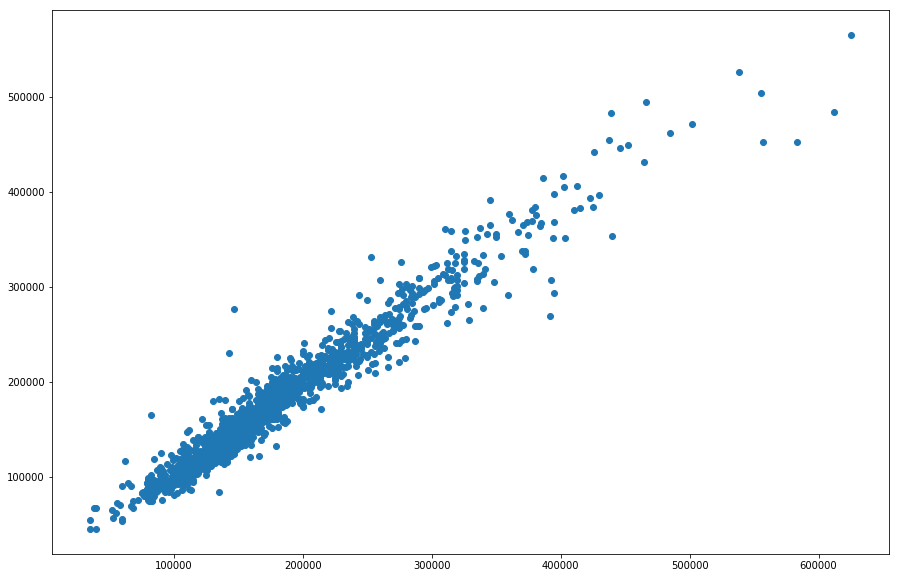

In [17]:
clf,ohe_cols,scalar_cols,col_dict,cols = model_test()

In [18]:
def predict_result(clf,ohe_cols,scalar_cols, col_dict):
    test_data = pd.read_csv('test.csv')
    test_features = get_features(test_data,ohe_cols,scalar_cols, False,col_dict,cols)
    print('Test features shape ',test_features.shape)
    p_values = np.floor(np.expm1(clf.predict(test_features)))
    predicted_values = test_data[['Id']]
    predicted_values=predicted_values.join(pd.DataFrame({'SalePrice':p_values}))
    predicted_values.to_csv('Predicted_Values.csv', index=False)

In [19]:
predict_result(clf,ohe_cols,scalar_cols, col_dict)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

SF                     1
GarageCars             1
baths                  2
GarageArea             1
LowQualFinSFPercent    1
dtype: int64
Test features shape  (1459, 210)


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
input_data = pd.read_csv('train.csv')

'''input_data['SaleCondition'].fillna('NA').value_counts().plot(kind='bar')'''
input_data['SF'] = input_data['1stFlrSF'] + input_data['2ndFlrSF'] + input_data['BsmtFinSF1'] + input_data['BsmtFinSF2'] + input_data['TotalBsmtSF']
input_data['SF'] += input_data['LotFrontage'] + input_data['GarageArea']+input_data['LotArea'] + input_data['GrLivArea']
x = np.power(input_data['SF'],(1/10))
s = input_data['CentralAir'].value_counts()
print(s)
x.hist(bins=100)






In [ ]:
ft = pd.read_csv('features.csv')

for col in ft.columns:
    s = ft[col].value_counts()
    print(s)
